### Advantage Actor Critic

Policy based methods update the policy based on how the agent has played. It will try and increase the probability of taking good actions and reduce the probability of taking bad actions. Unlike value based methods, which estimate the value of a state, and then choose the best action, policy based methods can handle continuous actions spaces (though also discrete by adding a argmax).

The method of updating a policy based agent can be derived.

There are several ways of getting the experiences to update the agent with. In the REINFORCE algorithm a monte-carol approach it taken. We let the agent play out an entire game, and then work out what the expected reward was. This will have low bias, because they will be all true events, however high variability because they might lead to completely different outcomes.

A in-between method is to use a value-based approach to guess how much the following steps are worth. For example, you might let the agent take 2 steps and then guess what the expected reward would be. This will then allow you to update the policy. However, because you’re making a guess, you’ll probably have a high bias, because we do not know what a good state is yet. on the flip side, we’ll have low variance as what we think is a good state now we’ll likely also still find a good state later. This means we end up training the agent faster and has less problem converging.

Over time the we’ll learn what a good value state is. This is what the actor citric method is. The actor makes the decisions and the critic tells us how good or bad those actions will be in the future.

In [24]:
%load_ext autoreload
%autoreload 2

import gym
from matplotlib import pyplot as plt
from collections import deque
import numpy as np

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [26]:
class Actor(nn.Module):
    """Some Information about ActorCritic"""
    def __init__(self, state_size, action_size):
        super(Actor, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(state_size, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, action_size)
        )

    def forward(self, x):
        return self.model(x)
    
class Critic(nn.Module):
    """Some Information about ActorCritic"""
    def __init__(self, state_size):
        super(Critic, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(state_size, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x)

class Memory:
    def __init__(self):
        self.log_probs = []
        self.values = []
        self.dones = []
        self.rewards = []
    
    def add(self, log_prob, value, done, reward):
        self.log_probs.append(log_prob)
        self.values.append(value)
        self.dones.append(done)
        self.rewards.append(reward)
    
    def clear(self):
        self.log_probs = []
        self.values = []
        self.dones = []
        self.rewards = []
    
    def __len__(self):
        return len(self.log_probs)

In [27]:
def update(mem, next_state):
    q_values = []
    
    # Do not add this one as it's for the next state
    running_reward = critic(torch.tensor(next_state).float().to(device))
    
    for reward, done in zip(reversed(mem.rewards), reversed(mem.dones)):
        running_reward = (reward + gamma * running_reward) * (1-done)
        
        q_values.append(running_reward)
    
    q_values = torch.stack(q_values).to(device)
    values = torch.stack(mem.values).to(device)
    log_probs = torch.stack(mem.log_probs).to(device)
    
    advantage = q_values - values
    
    critic_loss = torch.pow(advantage, 2).mean()
    actor_loss = (-log_probs * advantage).sum()
    
    critic_optim.zero_grad()
    critic_loss.backward(retain_graph=True)
    critic_optim.step()
    
    actor_optim.zero_grad()
    actor_loss.backward(retain_graph=True)
    actor_optim.step()

In [28]:
env = gym.make("CartPole-v1")
# env = gym.make("LunarLander-v2")


state_space = env.observation_space.shape[0]
action_space = env.action_space.n

In [29]:
win_condition = 200

num_episodes = 500
bootstrap_len = 5

gamma = 0.99

In [30]:
mem = Memory()

actor = Actor(state_space, action_space).to(device)
critic = Critic(state_space).to(device)

actor_optim = optim.Adam(actor.parameters(), lr=1e-3)
critic_optim = optim.Adam(critic.parameters(), lr=1e-3)

In [32]:
running_scores = deque(maxlen=100)
score_log = []
average_score_log = []


t = 0
for i in range(num_episodes):
    state = env.reset()
    steps = 0
    score = 0
    
    while True:
        steps += 1
            
        value = critic(torch.tensor(state).float().to(device))
        logits = F.softmax(actor(torch.tensor(state).float().to(device)))
        
        probabilities = Categorical(logits)
        action = probabilities.sample()
        log_probs = probabilities.log_prob(action)

        next_state, reward, done, _ = env.step(action.cpu().numpy())
        score += reward

        mem.add(log_probs, value, done, reward)

        if (done or steps % bootstrap_len == 0):
            update(mem, next_state)
            mem.clear()
        
        if done:
            break
        
        state = next_state

    score_log.append(score)
    running_scores.append(score)
    average_score_log.append(np.mean(running_scores))
    
    print("\rEpisode: {:.4f}\taverage: {:.4f}\tReward: {:.4f}".format(i, np.mean(running_scores), score), end="")
    
    if i % 100 == 0:
        print("\rEpisode: {:.4f}\taverage: {:.4f}\tReward: {:.4f}".format(i, np.mean(running_scores), score))
    
    if np.mean(running_scores) > win_condition:
        print("\rEnvironment Solved!")
        break

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


Episode: 0.0000	average: 41.0000	Reward: 41.0000
Episode: 100.0000	average: 119.8400	Reward: 500.0000
Episode: 127.0000	average: 202.1700	Reward: 369.0000Environment Solved!


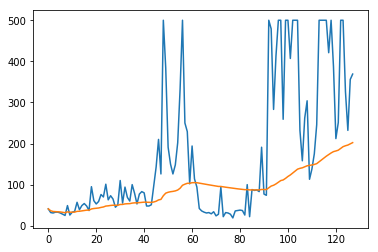

In [33]:
plt.plot(score_log)
plt.plot(average_score_log)